In [1]:
%pylab inline

import webdataset as wds
import zipfile
import json
import PIL
import io
import os

import pprint
pp = pprint.PrettyPrinter(indent=4, compact=True).pprint

!ls coco-raw

Populating the interactive namespace from numpy and matplotlib
annotations			       stuff_annotations_trainval2017.zip
annotations_trainval2017.zip	       test2017.zip
cocotext.v2.zip			       train2017.zip
image_info_test2017.zip		       unlabeled2017.zip
image_info_unlabeled2017.zip	       val2017.zip
panoptic_annotations_trainval2017.zip


In [2]:
annotations = zipfile.ZipFile("coco-raw/annotations_trainval2017.zip")

# Metadata (JSON Files)

In [3]:
META = {}

In [4]:
def add_images(top):
    global META
    result = []
    for image in top["images"]:
        assert "id" in image, image
        if image["id"] not in META:
            META[image["id"]] = image
        result.append(image["id"])
    return set(result)

## Annotations

In [5]:
def add_annotations():
    global META
    annotations_instances = json.loads(annotations.read("annotations/instances_train2017.json"))
    add_images(annotations_instances)
    for instance in annotations_instances["annotations"]:
        imid = instance["image_id"]
        META[imid].setdefault("annotations", []).append(instance)
add_annotations()

## Captions

In [6]:
def add_captions():
    global META
    for mode in ["train", "val"]:
        annotations_captions = json.loads(annotations.read(f"annotations/captions_{mode}2017.json"))
        ids = add_images(annotations_captions)
        for caption in annotations_captions["annotations"]:
            imid = caption["image_id"]
            if imid not in ids:
                print(f"{imid}: not found")
                break
            META[imid].setdefault("captions", []).append(caption)
add_captions()

## Person Keypoints

In [7]:
def add_persons():
    for mode in ["train", "val"]:
        annotations_person_keypoints = json.loads(annotations.read(f"annotations/person_keypoints_{mode}2017.json"))
        ids = add_images(annotations_person_keypoints)
        for person in annotations_person_keypoints["annotations"]:
            imid = person["image_id"]
            assert imid in ids
            META[imid].setdefault("person_keypoints", []).append(person)
add_persons()

## Stuff Annotations

In [8]:
def add_stuff():
    stuff_annotations = zipfile.ZipFile("coco-raw/stuff_annotations_trainval2017.zip")
    stuff_annotations.extract("annotations/stuff_train2017_pixelmaps.zip", path="coco-raw/")
    stuff_annotations.extract("annotations/stuff_val2017_pixelmaps.zip", path="coco-raw/")
    for mode in ["train", "val"]:
        stuff = json.loads(stuff_annotations.read(f"annotations/stuff_{mode}2017.json"))
        ids = add_images(stuff)
        for annotation in stuff["annotations"]:
            imid = annotation["image_id"]
            assert imid in ids
            annotation["segmentation"] = None
            META[imid].setdefault("stuff", []).append(annotation)
add_stuff()

## Panoptic Annotations

In [9]:
def add_panoptic():
    panoptic_annotations = zipfile.ZipFile("coco-raw/panoptic_annotations_trainval2017.zip")
    panoptic_annotations.extract("annotations/panoptic_train2017.zip", path="coco-raw/")
    panoptic_annotations.extract("annotations/panoptic_val2017.zip", path="coco-raw/")
    for mode in ["train", "val"]:
        panoptics = json.loads(panoptic_annotations.read(f"annotations/panoptic_{mode}2017.json"))
        ids = add_images(panoptics)
        for annotation in panoptics["annotations"]:
            imid = annotation["image_id"]
            assert imid in ids
            META[imid].setdefault("panoptics", []).append(annotation)
add_panoptic()

## CocoText

{   'area': 543.95,
    'bbox': [432.9, 159.0, 53.4, 15.9],
    'class': 'machine printed',
    'id': 30316,
    'image_id': 178242,
    'language': 'english',
    'legibility': 'legible',
    'mask': [432.9, 159.0, 432.9, 169.0, 486.3, 174.9, 485.2, 164.2],
    'utf8_string': 'VALPA'}


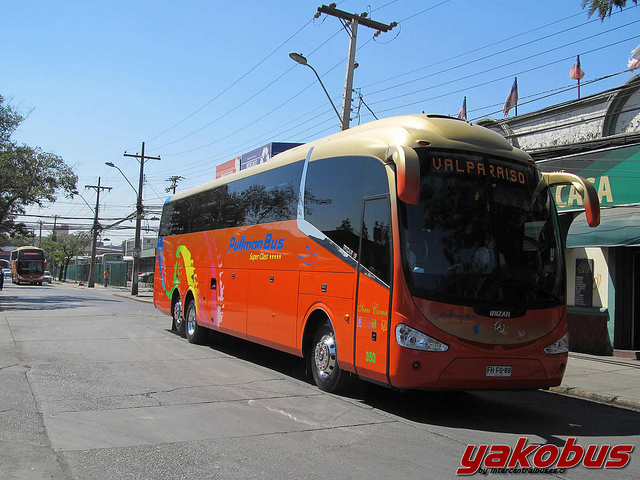

In [10]:
import json
cocotext = json.loads(zipfile.ZipFile("coco-raw/cocotext.v2.zip").read("cocotext.v2.json"))
cocotext.keys()

import pprint
pp = pprint.PrettyPrinter(indent=4, compact=True).pprint

from itertools import islice
ann = next(islice(iter(cocotext["anns"].values()), 100, 200))
pp(ann)

import PIL
import io
images = zipfile.ZipFile("coco-raw/train2017.zip")
image = PIL.Image.open(io.BytesIO(images.read("train2017/000000178242.jpg")))
image

In [11]:
def add_cocotext():
    cocotext = json.loads(zipfile.ZipFile("coco-raw/cocotext.v2.zip").read("cocotext.v2.json"))
    for annotation in cocotext["anns"].values():
        imid = annotation["image_id"]
        META[imid].setdefault("cocotext", []).append(annotation)
add_cocotext()

# Writing Shards

In [12]:
import re
def root(s):
    s = os.path.basename(s)
    s = re.sub(r"\..*$", "", s)
    return s

In [13]:
stuff_pixelmaps = dict(
    train=zipfile.ZipFile("coco-raw/annotations/stuff_train2017_pixelmaps.zip"),
    val=zipfile.ZipFile("coco-raw/annotations/stuff_val2017_pixelmaps.zip")
)
stuff_pixelmaps["train"].namelist()[:10]

['stuff_train2017_pixelmaps/',
 'stuff_train2017_pixelmaps/000000122611.png',
 'stuff_train2017_pixelmaps/000000080943.png',
 'stuff_train2017_pixelmaps/000000101647.png',
 'stuff_train2017_pixelmaps/000000455090.png',
 'stuff_train2017_pixelmaps/000000481165.png',
 'stuff_train2017_pixelmaps/000000141848.png',
 'stuff_train2017_pixelmaps/000000060327.png',
 'stuff_train2017_pixelmaps/000000551086.png',
 'stuff_train2017_pixelmaps/000000014029.png']

In [14]:
panoptic_pixelmaps = dict(
    train=zipfile.ZipFile("coco-raw/annotations/panoptic_train2017.zip"),
    val=zipfile.ZipFile("coco-raw/annotations/panoptic_val2017.zip")
)
panoptic_pixelmaps["train"].namelist()[:10]

['panoptic_train2017/',
 'panoptic_train2017/000000364853.png',
 'panoptic_train2017/000000095812.png',
 'panoptic_train2017/000000218224.png',
 'panoptic_train2017/000000375786.png',
 'panoptic_train2017/000000145831.png',
 'panoptic_train2017/000000056859.png',
 'panoptic_train2017/000000491883.png',
 'panoptic_train2017/000000049979.png',
 'panoptic_train2017/000000402027.png']

In [15]:
def make_stuffcmap():
    import scipy.spatial.distance as spd
    result = np.zeros((256, 3))
    for i in range(256):
        trial = np.floor(255.5*rand(16, 3))
        trial[:, 0] = i
        best = np.argmax(np.amin(spd.cdist(result, trial), axis=0))
        result[i] = trial[best]
    result = result.astype(int)
    return result
stuffcmap = make_stuffcmap()

In [16]:
stuffcmap[np.zeros((5, 5), dtype=int)].shape

(5, 5, 3)

In [17]:
stuff_pixelmaps["train"].namelist()[:10]

['stuff_train2017_pixelmaps/',
 'stuff_train2017_pixelmaps/000000122611.png',
 'stuff_train2017_pixelmaps/000000080943.png',
 'stuff_train2017_pixelmaps/000000101647.png',
 'stuff_train2017_pixelmaps/000000455090.png',
 'stuff_train2017_pixelmaps/000000481165.png',
 'stuff_train2017_pixelmaps/000000141848.png',
 'stuff_train2017_pixelmaps/000000060327.png',
 'stuff_train2017_pixelmaps/000000551086.png',
 'stuff_train2017_pixelmaps/000000014029.png']

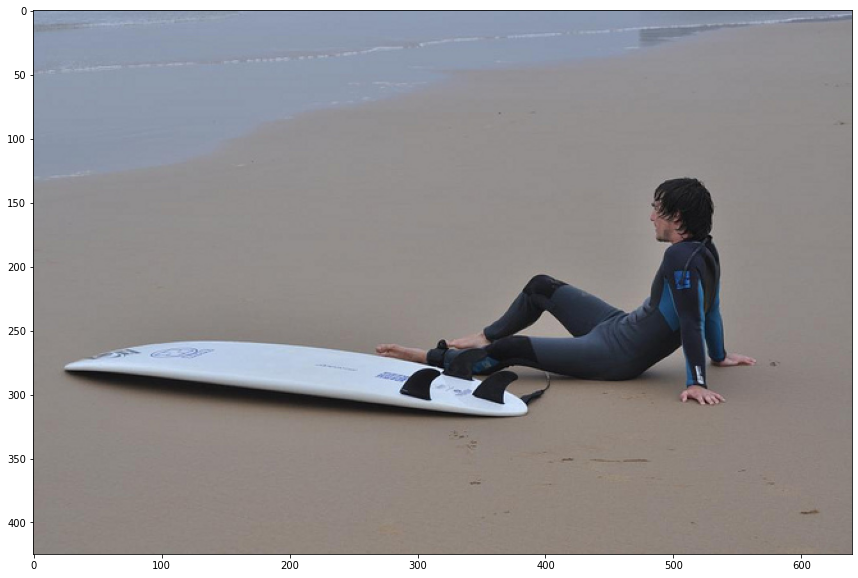

In [18]:
mode, s = "train", "000000014029"
images = zipfile.ZipFile(f"coco-raw/{mode}2017.zip")
jpg = PIL.Image.open(io.BytesIO(images.read(f"{mode}2017/{s}.jpg")))
figsize(20, 10)
imshow(jpg)

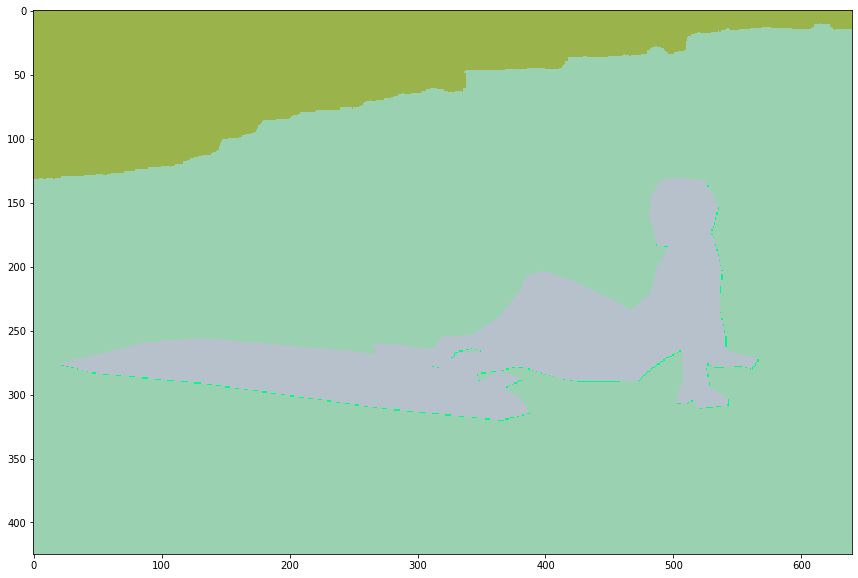

In [19]:
def pngvalues(data):
    import png
    import io
    r = png.Reader(file=io.BytesIO(data))
    w, h, rows, info = r.read()
    image = np.array([np.frombuffer(row, dtype=uint8) for row in rows], dtype=np.uint8)
    assert image.shape == (h, w)
    return image

def getstuff(mode, s):
    raw = stuff_pixelmaps[mode].read(f"stuff_{mode}2017_pixelmaps/{s}.png")
    values = pngvalues(raw)
    mapped = stuffcmap[values].astype(np.uint8)
    assert (mapped[:, :, 0] == values).all()
    return mapped

def rewritestuff(mode, s):
    seg = getstuff(mode, s)
    pil = PIL.Image.fromarray(seg)
    output = io.BytesIO()
    pil.save(output, format="png")
    data = output.getbuffer()
    return bytearray(data)

#seg = getstuff(mode, s)
seg = PIL.Image.open(io.BytesIO(rewritestuff(mode, s)))
imshow(seg, interpolation="nearest")

In [21]:
import random
missing_annotations = 0
total = 0
for mode in ["train", "val"]:
    images = zipfile.ZipFile(f"coco-raw/{mode}2017.zip")
    fnames = [s for s in images.namelist() if s.endswith(".jpg")]
    random.shuffle(fnames)
    sink = wds.ShardWriter(f"coco-{mode}-%06d.tar", maxcount=1000)
    textsink = wds.ShardWriter(f"cocotext-{mode}-%06d.tar", maxcount=1000)
    for i, fname in enumerate(fnames):
        #if i%100==0: print(i, fname)
        s = root(fname)
        mode = "train" if "train" in fname else "val"
        imid = int(s)
        jpg = images.read(f"{mode}2017/{s}.jpg")
        json = META[imid]
        # stuffpng = stuff_pixelmaps[mode].read(f"stuff_{mode}2017_pixelmaps/{s}.png")
        stuffpng = getstuff(mode, s)
        panopticpng = panoptic_pixelmaps[mode].read(f"panoptic_{mode}2017/{s}.png")
        sample = {
            "__key__": s,
            "jpg": jpg,
            "json": json,
            "stuff.png": stuffpng,
            "pan.png": panopticpng,
        }
        sink.write(sample)
        if "annotations" not in json:
            missing_annotations += 1
        if "cocotext" in json:
            textsink.write(sample)
        total += 1
    sink.close()
    textsink.close()
print("total", total, "missing annotations", missing_annotations)

# writing coco-train-000000.tar 0 0.0 GB 0
# writing cocotext-train-000000.tar 0 0.0 GB 0
# writing coco-train-000001.tar 1000 0.2 GB 1000
# writing coco-train-000002.tar 1000 0.2 GB 2000


KeyboardInterrupt: 

# Metadata (Category Names and Supercategory Relations)

In [21]:
import json
mode = "train"
metainfo = {}
annotations_instances = json.loads(annotations.read("annotations/instances_train2017.json"))
metainfo["annotations_categories"] = annotations_instances["categories"]
annotations_person_keypoints = json.loads(annotations.read(f"annotations/person_keypoints_{mode}2017.json"))
metainfo["person_categories"] = annotations_person_keypoints["categories"]
stuff_annotations = zipfile.ZipFile("coco-raw/stuff_annotations_trainval2017.zip")
stuff = json.loads(stuff_annotations.read(f"annotations/stuff_{mode}2017.json"))
metainfo["stuff_categories"] = stuff["categories"]
panoptic_annotations = zipfile.ZipFile("coco-raw/panoptic_annotations_trainval2017.zip")
panoptics = json.loads(panoptic_annotations.read(f"annotations/panoptic_{mode}2017.json"))
metainfo["panoptics_categories"] = panoptics["categories"]

In [22]:
with open("coco-meta.json", "w") as stream:
    json.dump(metainfo, stream, indent=4)